In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm


In [3]:
# read cleaned orders file
df = pd.read_csv('../datasets/cleaned_orders.csv')

# take some sample data
grouped = df[['order_date', 'item_id', 'item_quantity']]
groupedbyitem = grouped.groupby('item_id', group_keys=True).apply(lambda x:x)
groupedbyitem['item_id'].value_counts()

# take a specific item to perform predicion on
sample = groupedbyitem[groupedbyitem['item_id']=='Rara Neagră de Purcari 2020']
sample = sample.groupby('order_date')['item_quantity'].sum().reset_index()
sample['order_date'] = pd.to_datetime(sample['order_date'])
sample = sample.set_index('order_date')

for_model = pd.DataFrame()
# samples daily
for_model['qty'] = sample['item_quantity'].resample('D').mean()
for_model = for_model.fillna(0)
for_model

,qty
order_date,
2022-04-08,2.0
2022-04-09,0.0
2022-04-10,0.0
2022-04-11,0.0
2022-04-12,0.0
...,...
2023-07-10,0.0
2023-07-11,0.0
2023-07-12,1.0


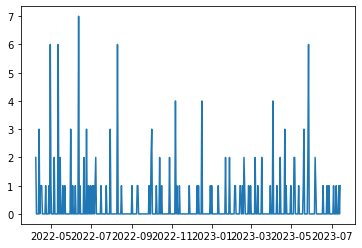

In [8]:
plt.plot(for_model) # is the data stationary?

## Augmented Dickey-Fuller Test
- statistical test called unit root test
- where the unit root is non-stationary
- hypothesis testing
    - H0: Series has a unit root (i.e. Non-stationary)
    - H1: Series does not have a unit root (i.e. Stationary)
- our conditions to reject H0 and say that data is stationary...
    - test statistic < critical value
    - p-value < 0.05

In [9]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(for_model, autolag='AIC')
output = pd.Series(test[0:4], index=['Test Stat','p-value','# Lags used','# Obsverations used'])

for key, value in test[4].items():
    output['Critical Value (%s)'%key] = value
print(output)

Test Stat               -22.069832
p-value                   0.000000
# Lags used               0.000000
# Obsverations used     462.000000
Critical Value (1%)      -3.444584
Critical Value (5%)      -2.867816
Critical Value (10%)     -2.570113
dtype: float64


- tstat < all critical values
- p-value < 0.05
#### Hence, reject H0. Data is stationary.

## KPSS Test
- unit root test similar to ADF, but cannot be used interchangeably with the ADF test beause the interpretation of p-value is opposite (H0 and H1 are swapped)
- hypothesis testing
    - H0: No unit root (i.e. stationary)
    - H1: Series has a unit root (i.e. non-stationary)
- our conditions to reject H0 and say that data is non-stationary...
    - test statistic < critical value
    - p-value < 0.05

In [10]:
from statsmodels.tsa.stattools import kpss

kpsstest = kpss(for_model, regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])

for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print(kpss_output)

Test Statistic           0.425392
p-value                  0.066210
#Lags Used               7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


- tstat < critical value at 95% confidence level
- p-value > 0.05
#### Hence, do not reject H0. Data is stationary.